<a href="https://colab.research.google.com/github/mehmetalivarol/veri-analitigi-egitim/blob/master/lstm_time_series_DZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from time import time
from scipy import stats
from statsmodels.tsa.stattools import adfuller

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

pd.set_option('display.float_format', lambda x: '%.4f' % x)
mpl.rcParams['figure.figsize'] = (12, 7)
mpl.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
warnings.filterwarnings('ignore')

In [12]:
df['Units'] = pd.to_numeric(df['Units'], errors='coerce')
df = df.dropna(subset=['Units'])

df=df.loc[:,['date','Units']]
df.sort_values('date', inplace=True, ascending=True)
df = df.reset_index(drop=True)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date.min())
print('The time series ends on: ', df.date.max())

Number of rows and columns after removing missing values: (761, 2)
The time series starts from:  2017-07-01 00:00:00
The time series ends on:  2019-07-31 00:00:00


In [13]:
df.head()

,date,Units
0,2017-07-01,67
1,2017-07-02,0
2,2017-07-03,275
3,2017-07-04,183
4,2017-07-05,176


In [14]:
stat, p = stats.normaltest(df.Units)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=36.186, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: -0.6616265159455672
Skewness of normal distribution: 0.1899422110534846


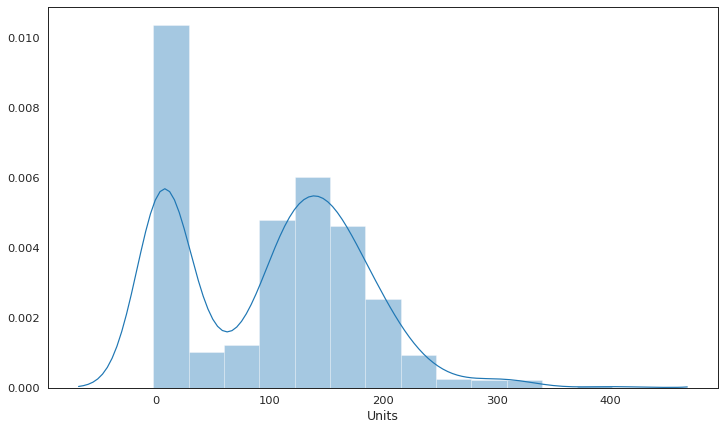

In [15]:
sns.distplot(df.Units);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Units)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Units)))

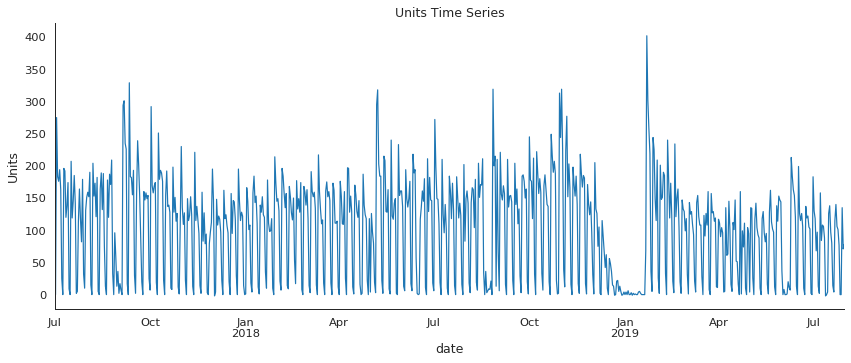

In [16]:
df1=df.loc[:,['date','Units']]
df1.set_index('date',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Units')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Units Time Series')
sns.despine(top=True)
plt.show();

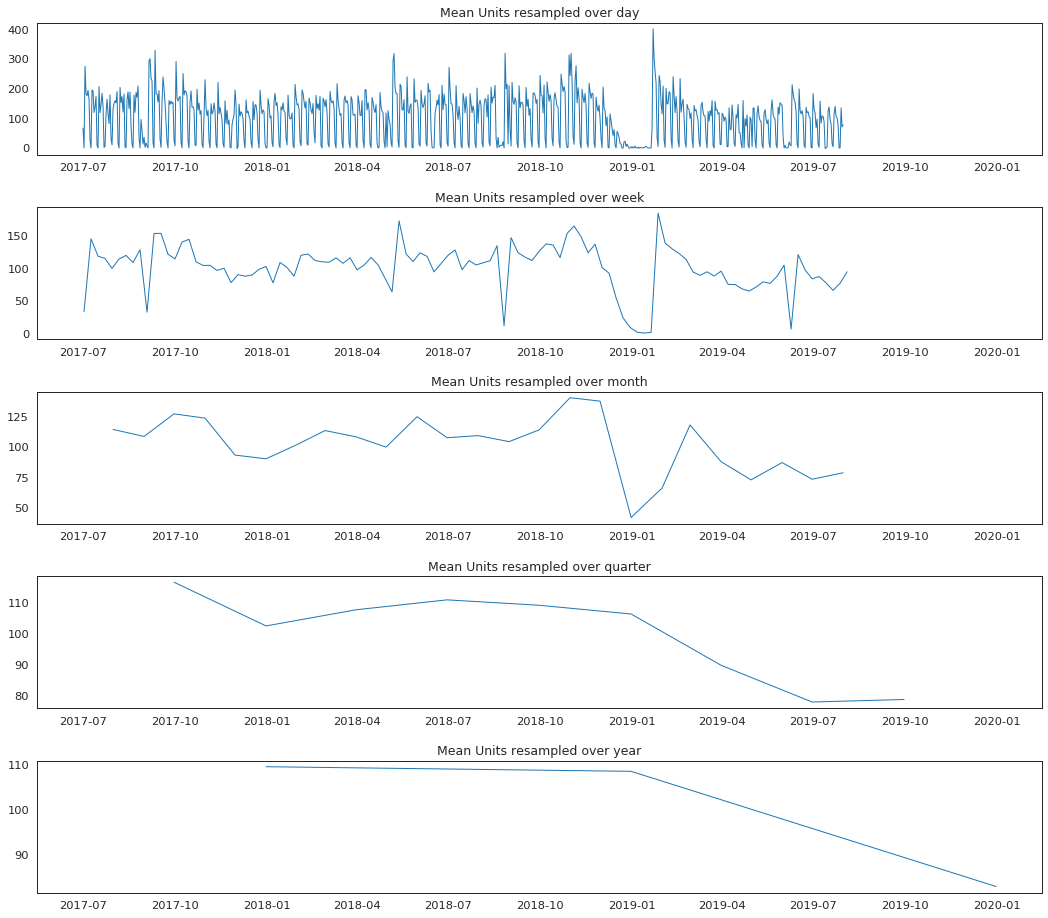

In [18]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Units'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Units resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Units'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Units resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Units'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Units resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Units'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Units resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Units'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Units resampled over year')
ax5.tick_params(axis='both', which='major');

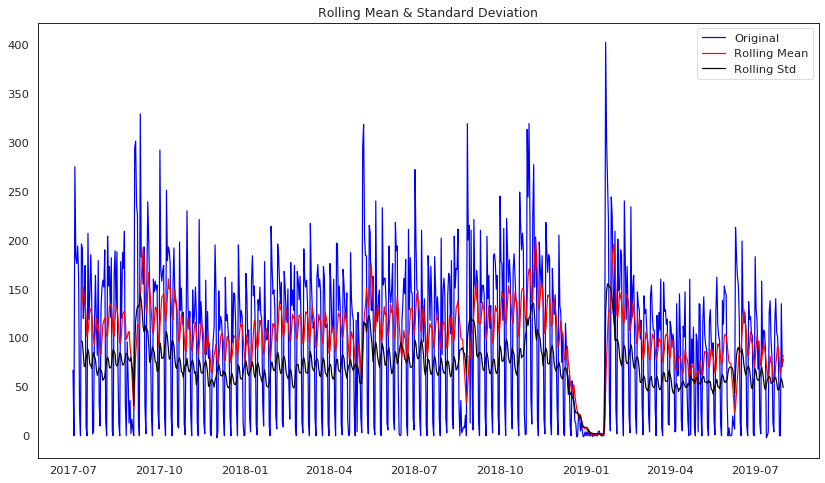

<Results of Dickey-Fuller Test>
Test Statistic                 -3.0706
p-value                         0.0288
#Lags Used                     20.0000
Number of Observations Used   740.0000
Critical Value (1%)            -3.4392
Critical Value (5%)            -2.8655
Critical Value (10%)           -2.5689
dtype: float64


In [23]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()
    
    plt.figure(figsize=(14,8))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Units.dropna())

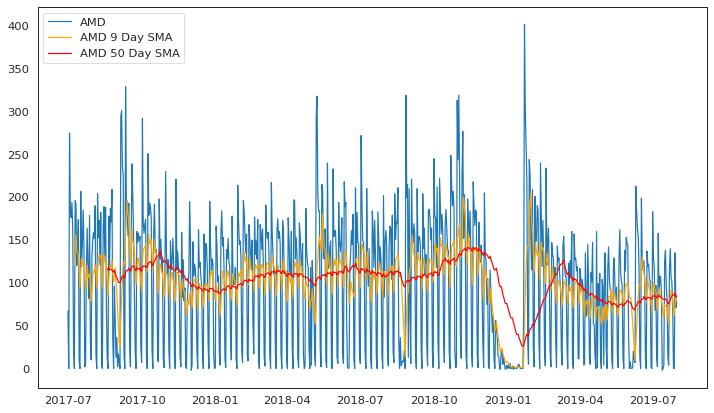

In [28]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

df['ma9'] = df.Units.rolling(window=9).mean()
rolling_mean = df.Units.rolling(window=9).mean()
rolling_mean2 = df.Units.rolling(window=50).mean()
plt.plot(df.date, df.Units, label='AMD')
plt.plot(df.date, rolling_mean, label='AMD 9 Day SMA', color='orange')
plt.plot(df.date, rolling_mean2, label='AMD 50 Day SMA', color='red')
plt.legend(loc='upper left')
plt.show()



In [0]:
df['loess_5'] = pd.DataFrame(lowess(df.Units, np.arange(len(df.Units)), frac=0.03)[:, 1], index=df.index, columns=['Units'])

In [29]:
df.head(20)

,date,Units,ma9,loess_5
0,2017-07-01,67,nan,136.5964
1,2017-07-02,0,nan,136.7254
2,2017-07-03,275,nan,136.6457
3,2017-07-04,183,nan,136.4926
4,2017-07-05,176,nan,136.3673
5,2017-07-06,194,nan,136.3238
6,2017-07-07,163,nan,136.3608
7,2017-07-08,25,nan,136.3805
8,2017-07-09,0,120.3333,136.1480
9,2017-07-10,196,134.6667,135.2445


In [0]:
dataset = df.ma9[8:761].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [39]:
from keras import optimizers
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
Adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='Adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size= 16, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience= 10)], verbose=1, shuffle=False)
model.summary()

Train on 571 samples, validate on 120 samples
Epoch 1/100
571/571 [==============================] - 5s 9ms/step - loss: 0.1883 - val_loss: 0.0178
Epoch 2/100
571/571 [==============================] - 0s 673us/step - loss: 0.0331 - val_loss: 0.0154
Epoch 3/100
571/571 [==============================] - 0s 652us/step - loss: 0.0264 - val_loss: 0.0132
Epoch 4/100
571/571 [==============================] - 0s 672us/step - loss: 0.0247 - val_loss: 0.0141
Epoch 5/100
571/571 [==============================] - 0s 678us/step - loss: 0.0215 - val_loss: 0.0130
Epoch 6/100
571/571 [==============================] - 0s 668us/step - loss: 0.0208 - val_loss: 0.0103
Epoch 7/100
571/571 [==============================] - 0s 662us/step - loss: 0.0191 - val_loss: 0.0091
Epoch 8/100
571/571 [==============================] - 0s 636us/step - loss: 0.0172 - val_loss: 0.0072
Epoch 9/100
571/571 [==============================] - 0s 676us/step - loss: 0.0159 - val_loss: 0.0052
Epoch 10/100
571/571 [=======

In [40]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))



Train Mean Absolute Error: 15.128484148976025
Train Root Mean Squared Error: 16.708435116664276
Test Mean Absolute Error: 17.288932950720994
Test Root Mean Squared Error: 18.648603543036458


In [41]:
df['Units'].mean()

101.6688567674113

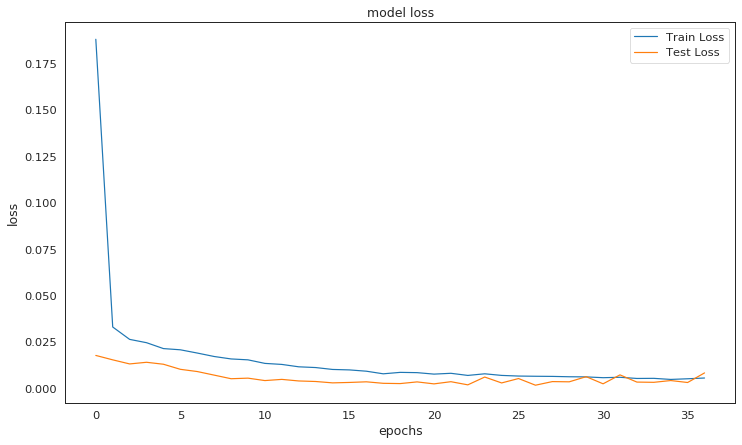

In [42]:
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

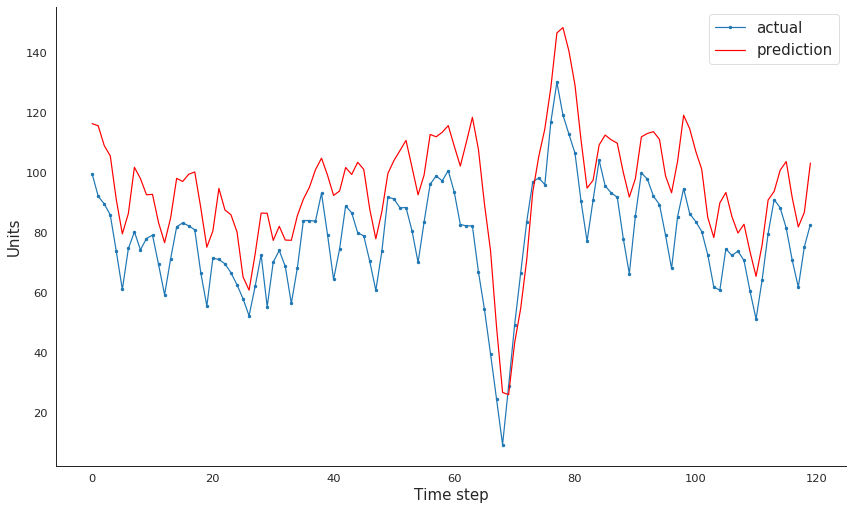

In [43]:
aa=[x for x in range(120)]
plt.figure(figsize=(12,7))
plt.plot(aa, Y_test[0][:120], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:120], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Units', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();